# Sparkify Capstone Project

First pip install pyspark if it is not already installed

In [1]:
!pip install pyspark

We need to first load in the necessary pyspark libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as _sum
from pyspark.sql.types import FloatType

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.linalg import Vectors

In [3]:
spark = SparkSession \
    .builder \
    .appName("Data Frames practice") \
    .getOrCreate()

user_event_data = spark.read.json("medium-sparkify-event-data.json")

# Data Exploration

In [4]:
user_event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
user_event_data.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+---------

In [6]:
user_event_data.count()

543705

### Most Visited Pages

In [7]:
user_event_data.groupBy('page') \
  .count()\
  .sort(desc("count"))\
  .show(25)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|432877|
|                Home| 27412|
|           Thumbs Up| 23826|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|         Roll Advert|  7773|
|               Login|  6011|
|              Logout|  5990|
|         Thumbs Down|  4911|
|           Downgrade|  3811|
|                Help|  3150|
|            Settings|  2964|
|               About|  1855|
|             Upgrade|   968|
|       Save Settings|   585|
|               Error|   519|
|      Submit Upgrade|   287|
|    Submit Downgrade|   117|
|              Cancel|    99|
|Cancellation Conf...|    99|
|            Register|    11|
| Submit Registration|     4|
+--------------------+------+



### User IDs
Lets investigate how many users we have in the dataset and if there are any obvious things we need to clean up

In [8]:
user_event_data.select('userId')\
  .dropDuplicates()\
  .count()

449

In [9]:
user_event_data.groupBy('userId') \
  .count()\
  .sort(desc("count"))\
  .show(5)

+------+-----+
|userId|count|
+------+-----+
|      |15700|
|    92| 9767|
|   140| 7448|
|300049| 7309|
|   101| 6842|
+------+-----+
only showing top 5 rows



It is clear that we have a blank userId that has a very high record count and it is going to have an affect on our results. Thus we need to investigate it and then determine if we can remove it from our dataset

In [10]:
user_event_data.filter(user_event_data.userId=='') \
  .groupBy('page') \
  .count()\
  .sort(desc("count"))\
  .show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 8323|
|              Login| 6011|
|              About|  829|
|               Help|  506|
|              Error|   16|
|           Register|   11|
|Submit Registration|    4|
+-------------------+-----+



It appears that the blank User Id mostly is related to users that are visiting our Home page or Login page and will not be related in any meaningful way to our churn analysis

In [11]:
user_event_valid_id = user_event_data.dropna(how = "any", subset = ["userId", "sessionId"])
user_event_valid_id = user_event_valid_id.filter(user_event_valid_id["userId"] != "")

### Churned Users Counts

In [12]:
user_event_valid_id.filter(user_event_valid_id.page=='Cancellation Confirmation') \
  .groupBy('gender') \
  .count()\
  .show(2)

+------+-----+
|gender|count|
+------+-----+
|     F|   45|
|     M|   54|
+------+-----+



# Create Truth Set
Determine the users that are cancelling their services (Churning) and label them as 1 and those that havent cancelled their service as 0

In [13]:
labeled_df = user_event_valid_id.withColumn('churned', (when(col('page')== 'Cancellation Confirmation',1)\
                                                            .otherwise(0)))
                                            

In [14]:
user_labeled_df = labeled_df.groupby('userId')\
                       .agg(_sum('churned')\
                       .alias('churned'))

In [15]:
user_labeled_df.show(2)

+------+-------+
|userId|churned|
+------+-------+
|   296|      1|
|100010|      1|
+------+-------+
only showing top 2 rows



In [16]:
user_labeled_df.groupBy('churned')\
               .count()\
               .show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  349|
|      1|   99|
+-------+-----+



Out of our total number of 448 users 349 are subscribers and 99 are no longer subscribers and have churned. This is a bit unbalanced but not as bad as many fraud datasets. What is not ideal for a machine learning algorithm is that despite starting with what seemed to be a resonably large dataset of 543705 rows of logs there are effectively only 448 data points in our model. 

#### EDA Chart Churn by Gender

In [17]:
eda = user_labeled_df.join(user_event_valid_id, on = 'userId')\
                        .select('userId','gender','churned')\
                        .dropDuplicates()\
                        .groupBy('gender','churned')\
                        .count()\
                        .toPandas()

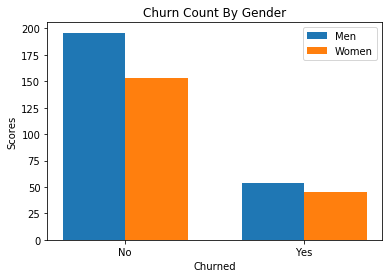

In [18]:
N = 2
men_means = eda[eda.gender=="M"]['count']
women_means = eda[eda.gender=="F"]['count']

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, men_means, width, label='Men')
plt.bar(ind + width, women_means, width,
    label='Women')

plt.ylabel('Scores')
plt.xlabel('Churned')
plt.title('Churn Count By Gender')

plt.xticks(ind + width / 2, ('No', 'Yes'))
plt.legend(loc='best')
plt.show()

# Generate User Behavior Features
Now that we have the user truth values we need to generate aggregated features about the user behavior that we know before the user decides to churn. We will then use those features to predict if a user will churn based on their behavior. This will allow us to potentially keep more customers on our service and grow revenue and profit for the company.

## Feature 1 : Count of Thumbs:  up / down / total
I think that the more a user gives songs thumbs up the less likely they are to churn and the more they give songs thumbs down the more likely they are to churn

### 1.a countThumbsUp
a count of the times a user has given a thumbs up

In [19]:
# Thumbs Up
labeled_df = labeled_df.withColumn('ThumbsUp', (when(col('page')== 'Thumbs Up',1)\
                                                            .otherwise(0)))
user_thumbsUp_df = labeled_df.groupby('userId')\
                       .agg(_sum('ThumbsUp')\
                       .alias('countThumbsUp'))

##### Feature Summary

In [20]:
user_thumbsUp_df.dropDuplicates()\
                .describe('countThumbsUp')\
                .show()

+-------+------------------+
|summary|     countThumbsUp|
+-------+------------------+
|  count|               448|
|   mean|53.183035714285715|
| stddev| 69.65210755898286|
|    min|                 0|
|    max|               506|
+-------+------------------+



In [21]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(user_thumbsUp_df, 'userId')
user_labeled_df.show(5)

+------+-------+-------------+
|userId|churned|countThumbsUp|
+------+-------+-------------+
|100010|      1|            4|
|200002|      1|           15|
|   296|      1|            8|
|   125|      0|            3|
|   124|      1|          102|
+------+-------+-------------+
only showing top 5 rows



#### EDA of Count of Thumbs Up

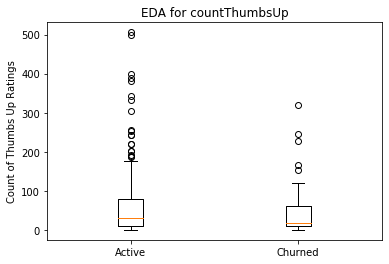

Median for Active subscribers: 31.0
Median for Churned subscribers: 17.0


In [22]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countThumbsUp.values, 'Churned': churn.countThumbsUp.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countThumbsUp")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Thumbs Up Ratings")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countThumbsUp.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countThumbsUp.values),3))

### 1.b countThumbsDown
a count of the times a user has given a thumbs down

In [23]:
# Thumbs Down
labeled_df = labeled_df.withColumn('ThumbsDown', (when(col('page')== 'Thumbs Down',1)\
                                                            .otherwise(0)))
user_thumbsDown_df = labeled_df.groupby('userId')\
                       .agg(_sum('ThumbsDown')\
                       .alias('countThumbsDown'))

##### Feature Summary

In [24]:
user_thumbsDown_df.dropDuplicates()\
                .describe('countThumbsDown')\
                .show()

+-------+------------------+
|summary|   countThumbsDown|
+-------+------------------+
|  count|               448|
|   mean|10.962053571428571|
| stddev|13.356609011067468|
|    min|                 0|
|    max|                80|
+-------+------------------+



In [25]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(user_thumbsDown_df, 'userId')
user_labeled_df.show(5)

+------+-------+-------------+---------------+
|userId|churned|countThumbsUp|countThumbsDown|
+------+-------+-------------+---------------+
|100010|      1|            4|              3|
|200002|      1|           15|              5|
|   296|      1|            8|              0|
|   125|      0|            3|              1|
|   124|      1|          102|             15|
+------+-------+-------------+---------------+
only showing top 5 rows



#### EDA of Count of Thumbs Down

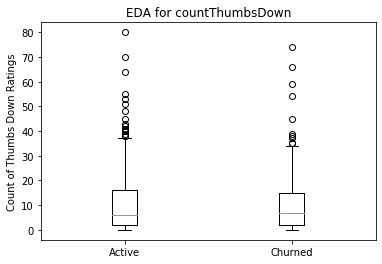

Median for Active subscribers: 6.0
Median for Churned subscribers: 7.0


In [26]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countThumbsDown.values, 'Churned': churn.countThumbsDown.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countThumbsDown")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Thumbs Down Ratings")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countThumbsDown.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countThumbsDown.values),3))

#### EDA Chart Churn and Count of Thumbs Up / Thumbs Down

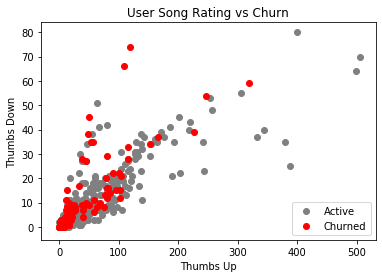

In [27]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plt.scatter(noChurn.countThumbsUp,noChurn.countThumbsDown,color='gray',label='Active')
plt.scatter(churn.countThumbsUp,churn.countThumbsDown,color='red',label='Churned')

plt.ylabel('Thumbs Down')
plt.xlabel('Thumbs Up')
plt.title('User Song Rating vs Churn')
plt.legend(loc='lower right')
plt.show()

### 1.c Total Thumbs
Another easy feature to add is total between thumbs up and thumbs down. This can allow us to create percentage based features for users that are

In [28]:
user_labeled_df = user_labeled_df.withColumn('totalThumbs',user_labeled_df.countThumbsUp + user_labeled_df.countThumbsDown)
user_labeled_df.show(5)

+------+-------+-------------+---------------+-----------+
|userId|churned|countThumbsUp|countThumbsDown|totalThumbs|
+------+-------+-------------+---------------+-----------+
|100010|      1|            4|              3|          7|
|200002|      1|           15|              5|         20|
|   296|      1|            8|              0|          8|
|   125|      0|            3|              1|          4|
|   124|      1|          102|             15|        117|
+------+-------+-------------+---------------+-----------+
only showing top 5 rows



##### Feature Summary

In [29]:
user_labeled_df.describe('totalThumbs')\
               .show()

+-------+-----------------+
|summary|      totalThumbs|
+-------+-----------------+
|  count|              448|
|   mean|64.14508928571429|
| stddev|80.93833885241825|
|    min|                0|
|    max|              576|
+-------+-----------------+



#### EDA Chart Churn and Count of Logins

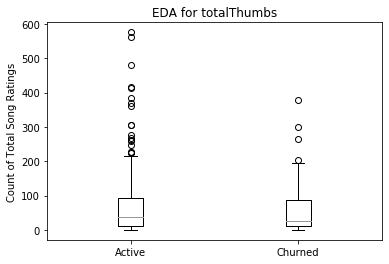

Median for Active subscribers: 38.0
Median for Churned subscribers: 25.0


In [30]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.totalThumbs.values, 'Churned': churn.totalThumbs.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for totalThumbs")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Total Song Ratings")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.totalThumbs.values),3))
print("Median for Churned subscribers:",round(np.median(churn.totalThumbs.values),3))

## Feature 2 : Number of Logins
I assume that the more a user engages with the service the more likely they are to not churn

In [31]:

num_logins_df = user_event_valid_id\
                   .select('userId','sessionId')\
                   .dropDuplicates()\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countLogins")

##### Feature Summary

In [32]:
num_logins_df.describe('countLogins')\
             .show()

+-------+------------------+
|summary|       countLogins|
+-------+------------------+
|  count|               448|
|   mean|13.571428571428571|
| stddev|13.171023911802262|
|    min|                 1|
|    max|                92|
+-------+------------------+



In [33]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_logins_df, 'userId')
user_labeled_df.show(5)

+------+-------+-------------+---------------+-----------+-----------+
|userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|
+------+-------+-------------+---------------+-----------+-----------+
|100010|      1|            4|              3|          7|          2|
|200002|      1|           15|              5|         20|          5|
|   296|      1|            8|              0|          8|          5|
|   125|      0|            3|              1|          4|          3|
|   124|      1|          102|             15|        117|         17|
+------+-------+-------------+---------------+-----------+-----------+
only showing top 5 rows



#### EDA Chart Churn and Count of Total Ratings

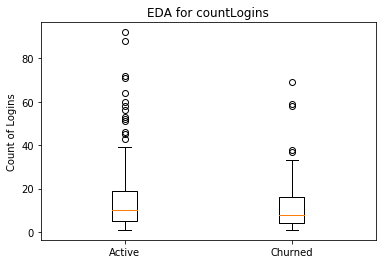

Median for Active subscribers: 10.0
Median for Churned subscribers: 8.0


In [34]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countLogins.values, 'Churned': churn.countLogins.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countLogins")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Logins")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countLogins.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countLogins.values),3))

## Feature 3 : Number of Friends
I assume that the more friends a user has the more likely they will stay on our service. 

In [35]:
num_friends_df = user_event_valid_id\
                   .filter(user_event_valid_id.page=="Add Friend")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countFriends")

##### Feature Summary

In [36]:
num_friends_df.describe('countFriends')\
              .show()

+-------+------------------+
|summary|      countFriends|
+-------+------------------+
|  count|               409|
|   mean|19.772616136919314|
| stddev|22.494435766272833|
|    min|                 1|
|    max|               158|
+-------+------------------+



In [37]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_friends_df, 'userId')
user_labeled_df.show(5)

+------+-------+-------------+---------------+-----------+-----------+------------+
|userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|
+------+-------+-------------+---------------+-----------+-----------+------------+
|100010|      1|            4|              3|          7|          2|           3|
|200002|      1|           15|              5|         20|          5|           2|
|   296|      1|            8|              0|          8|          5|           2|
|   125|      0|            3|              1|          4|          3|           3|
|   124|      1|          102|             15|        117|         17|          26|
+------+-------+-------------+---------------+-----------+-----------+------------+
only showing top 5 rows



#### EDA Chart Churn and Number of Friends

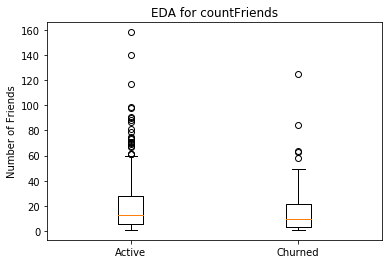

Median Active subscribers: 12.5
Median Churned subscribers: 10.0


In [38]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countFriends.values, 'Churned': churn.countFriends.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countFriends")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Number of Friends")
plt.show()
print("Median Active subscribers:",round(np.median(noChurn.countFriends.values),3))
print("Median Churned subscribers:",round(np.median(churn.countFriends.values),3))

## Feature 4 : Number of Errors
I assume that the more errors a user faces especially compared to the number of songs they listen to the more likely they are to churn

In [39]:
num_errors_df = user_event_valid_id\
                   .filter(user_event_valid_id.page=="Error")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countErrors")

##### Feature Summary

In [40]:
num_errors_df.describe('countErrors')\
              .show()

+-------+------------------+
|summary|       countErrors|
+-------+------------------+
|  count|               223|
|   mean|2.2556053811659194|
| stddev|1.7686337339924163|
|    min|                 1|
|    max|                13|
+-------+------------------+



In [41]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_errors_df, 'userId')
user_labeled_df.show(5)

+------+-------+-------------+---------------+-----------+-----------+------------+-----------+
|userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|countErrors|
+------+-------+-------------+---------------+-----------+-----------+------------+-----------+
|    51|      1|           16|              1|         17|          5|           3|          2|
|   205|      0|           50|             10|         60|          5|          21|          1|
|    15|      0|           93|             16|        109|         18|          32|          1|
|   232|      0|           97|             17|        114|         23|          43|          1|
|   234|      1|           91|             22|        113|         26|          17|          2|
+------+-------+-------------+---------------+-----------+-----------+------------+-----------+
only showing top 5 rows



#### EDA Chart Churn and Count of Errors

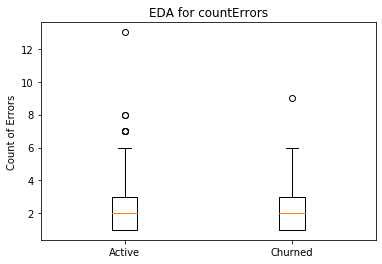

Median for Active subscribers: 2.0
Median for Churned subscribers: 2.0


In [42]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countErrors.values, 'Churned': churn.countErrors.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countErrors")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Errors")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countErrors.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countErrors.values),3))

## Feature 5 : Number of visits to the help page
I assume that the more visits to the help page the more likely a user is to be having trouble with the service and is thus more likely to leave

In [43]:
num_help_df = user_event_valid_id\
                   .filter(user_event_valid_id.page=="Help")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countHelp")

##### Feature Summary

In [44]:
num_help_df.describe('countHelp')\
              .show()

+-------+-----------------+
|summary|        countHelp|
+-------+-----------------+
|  count|              360|
|   mean|7.344444444444444|
| stddev|7.482065630371307|
|    min|                1|
|    max|               62|
+-------+-----------------+



In [45]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_help_df, 'userId')
user_labeled_df.show(5)

+------+-------+-------------+---------------+-----------+-----------+------------+-----------+---------+
|userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|countErrors|countHelp|
+------+-------+-------------+---------------+-----------+-----------+------------+-----------+---------+
|   205|      0|           50|             10|         60|          5|          21|          1|       11|
|    15|      0|           93|             16|        109|         18|          32|          1|       12|
|   232|      0|           97|             17|        114|         23|          43|          1|       21|
|   234|      1|           91|             22|        113|         26|          17|          2|        7|
|   282|      0|          133|             29|        162|         29|          79|          4|       19|
+------+-------+-------------+---------------+-----------+-----------+------------+-----------+---------+
only showing top 5 rows



#### EDA Chart Churn and Count of Help Page Visits

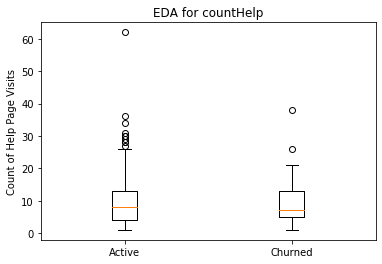

Median for Active subscribers: 8.0
Median for Churned subscribers: 7.0


In [46]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countHelp.values, 'Churned': churn.countHelp.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countHelp")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Help Page Visits")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countHelp.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countHelp.values),3))

## Feature 6 : Number of Songs
If a user listens to a lot of songs they are likely to be engaged and probably enjoy using the service

In [47]:
num_songs_df = user_event_valid_id\
                   .select('userId','song')\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countSong")

#### Feature Summary

In [48]:
num_songs_df.describe('countSong')\
              .show()

+-------+------------------+
|summary|         countSong|
+-------+------------------+
|  count|               448|
|   mean|1178.5825892857142|
| stddev|1380.6279647524045|
|    min|                 3|
|    max|              9767|
+-------+------------------+



In [49]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_songs_df, 'userId')

#### EDA Chart Churn and Count of Songs A User Has Listened To

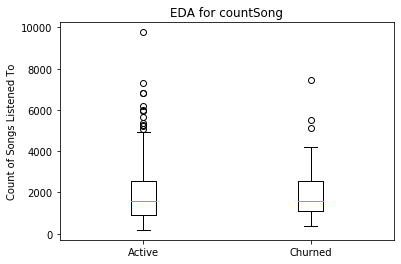

Median for Active subscribers: 1563.0
Median for Churned subscribers: 1571.0


In [50]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countSong.values, 'Churned': churn.countSong.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countSong")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Songs Listened To")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countSong.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countSong.values),3))

## Feature 7 : Percent of Sessions Paid vs Free


In [51]:
mean_level_df = user_event_valid_id\
                   .select('userId','level')\
                   .withColumn('levelBinary', (when(col('level')== 'free',0)\
                                                            .otherwise(1)))\
                   .groupBy('userId')\
                   .agg(avg('levelBinary')\
                       .alias('meanLevel'))

#### Feature Summary

In [52]:
mean_level_df.describe('meanLevel')\
              .show()

+-------+-------------------+
|summary|          meanLevel|
+-------+-------------------+
|  count|                448|
|   mean| 0.5608038780418371|
| stddev|0.41286879860171066|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [53]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(mean_level_df, 'userId')

#### EDA Chart Churn and Percent of Time on Paid vs Free Subscription

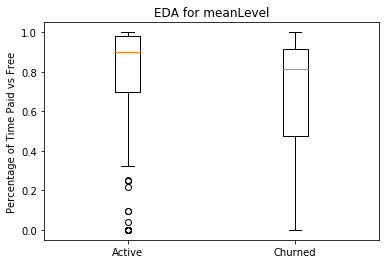

Median for Active subscribers: 0.9
Median for Churned subscribers: 0.813


In [54]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.meanLevel.values, 'Churned': churn.meanLevel.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for meanLevel")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Percentage of Time Paid vs Free")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.meanLevel.values),3))
print("Median for Churned subscribers:",round(np.median(churn.meanLevel.values),3))

## Interaction Features
The way features interact with eachother may be useful like the number of errors in a session or the percentage of thumbs up vs thumbs down a user gives to songs.

In [55]:
user_labeled_df = user_labeled_df.withColumn('percThumbsUp',\
                                             user_labeled_df.countThumbsUp / user_labeled_df.totalThumbs)

#### EDA Chart Churn and Percent of Ratings that are Thumbs Up

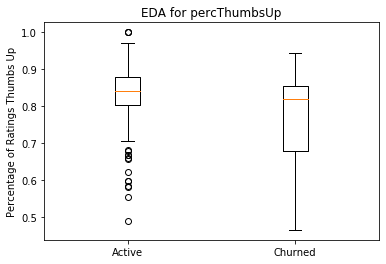

Median for Active subscribers: 0.841
Median for Churned subscribers: 0.82


In [56]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.percThumbsUp.values, 'Churned': churn.percThumbsUp.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for percThumbsUp")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Percentage of Ratings Thumbs Up")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.percThumbsUp.values),3))
print("Median for Churned subscribers:",round(np.median(churn.percThumbsUp.values),3))

In [57]:
user_labeled_df = user_labeled_df.withColumn('errorsPerLogin',\
                                             user_labeled_df.countErrors / user_labeled_df.countLogins)

#### EDA Chart Churn and Errors per Login

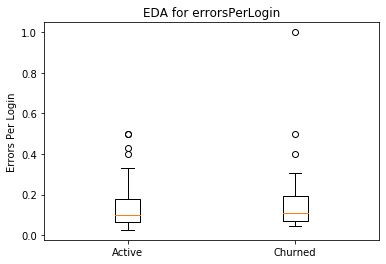

Median for Active subscribers: 0.1
Median for Churned subscribers: 0.111


In [58]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.errorsPerLogin.values, 'Churned': churn.errorsPerLogin.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for errorsPerLogin")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Errors Per Login")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.errorsPerLogin.values),3))
print("Median for Churned subscribers:",round(np.median(churn.errorsPerLogin.values),3))

In [59]:
user_labeled_df = user_labeled_df.withColumn('helpPerLogin',\
                                             user_labeled_df.countHelp / user_labeled_df.countLogins)

#### EDA Chart Churn and Help Page Visits per Login

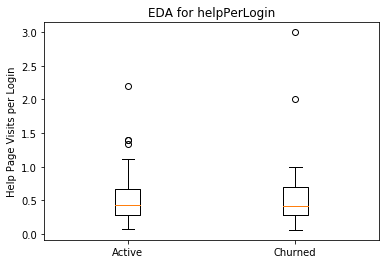

Median for Active subscribers: 0.429
Median for Churned subscribers: 0.419


In [60]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.helpPerLogin.values, 'Churned': churn.helpPerLogin.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for helpPerLogin")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Help Page Visits per Login")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.helpPerLogin.values),3))
print("Median for Churned subscribers:",round(np.median(churn.helpPerLogin.values),3))

In [61]:
user_labeled_df = user_labeled_df.withColumn('songsPerLogin',\
                                             user_labeled_df.countSong / user_labeled_df.countLogins)

#### EDA Chart Churn and Songs per Login

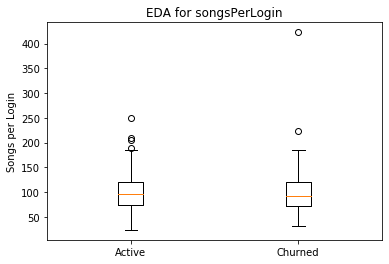

Median for Active subscribers: 95.25
Median for Churned subscribers: 91.889


In [62]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.songsPerLogin.values, 'Churned': churn.songsPerLogin.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for songsPerLogin")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Songs per Login")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.songsPerLogin.values),3))
print("Median for Churned subscribers:",round(np.median(churn.songsPerLogin.values),3))

### Final Dataframe

In [63]:
# reorder for ML feature selection and remove userId
final_user_labeled_df = user_labeled_df.select('countThumbsUp','percThumbsUp','countThumbsDown','totalThumbs',
                                         'countLogins','countFriends','countErrors','errorsPerLogin',
                                         'countHelp','helpPerLogin','countSong','songsPerLogin','meanLevel',
                                         'churned')
final_user_labeled_df.show(5)

+-------------+------------------+---------------+-----------+-----------+------------+-----------+--------------------+---------+------------------+---------+------------------+------------------+-------+
|countThumbsUp|      percThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|countErrors|      errorsPerLogin|countHelp|      helpPerLogin|countSong|     songsPerLogin|         meanLevel|churned|
+-------------+------------------+---------------+-----------+-----------+------------+-----------+--------------------+---------+------------------+---------+------------------+------------------+-------+
|           50|0.8333333333333334|             10|         60|          5|          21|          1|                 0.2|       11|               2.2|     1244|             248.8|               1.0|      0|
|           93|0.8532110091743119|             16|        109|         18|          32|          1| 0.05555555555555555|       12|0.6666666666666666|     2173|120.7222222222222

# Training & Test Split
In order to ensure the fitted model is extensible to new data that it hasnt trained on I am going to split 80% for training data and 20% for test data

In [64]:
# the data needs to be mapped into a features column with a vector of the features and a label column with the target
trainingData=final_user_labeled_df.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
trainingData.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[50.0,0.833333333...|    0|
|[93.0,0.853211009...|    0|
|[97.0,0.850877192...|    0|
|[91.0,0.805309734...|    1|
|[133.0,0.82098765...|    0|
+--------------------+-----+
only showing top 5 rows



In [65]:
train, validation = trainingData.randomSplit([0.9, 0.1], seed=1842)

## Metrics and Plot Helper functions

In [66]:
def plot_roc(y,preds):
    """
    This function takes in:
    y - the label
    preds - the predicted probability that the model gives for a 1
    """
    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-.01, 1])
    plt.ylim([0, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [67]:
"""
PySpark User defined functions to parse out values from an array in a column
this is useful for parsing out the probablility of a 0 and 1 from the predictions made from model.transform(df)
"""
split0_udf = udf(lambda value: value[0].item(), FloatType())
split1_udf = udf(lambda value: value[1].item(), FloatType())

# Logistic Regression Model 
both basic and with Grid Search and Train/Validation Split

In [68]:
lr = LogisticRegression(maxIter=10)

model = lr.fit(train)

In [69]:
lr_train_preds = model.transform(train)
lr_test_preds = model.transform(validation)

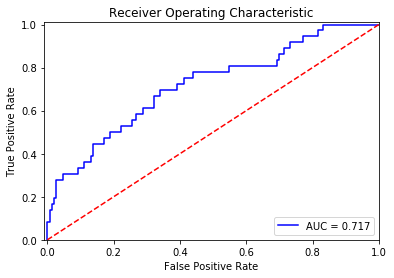

In [70]:
train_preds = lr_train_preds.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = train_preds.prob1
y = train_preds.label
plot_roc(y,preds)

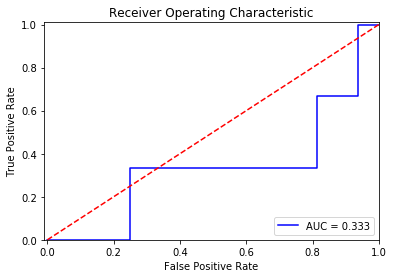

In [71]:
test_preds = lr_test_preds.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

### Analysis of Logistic Regression

This model is obviously overfit because the AUC drops by about .4 from training to test sets! In order to combat the overfitting a parameter grid search can be used to use some elastic net regularization as well as if an intercept should be fit or not. That should make a more generalizable model

### Train Validation Split Logistic Regression

In [72]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

tvs_model = tvs.fit(train)
tvs_train_preds = tvs_model.transform(train)
tvs_test_predictions = tvs_model.transform(validation)

### Train Results

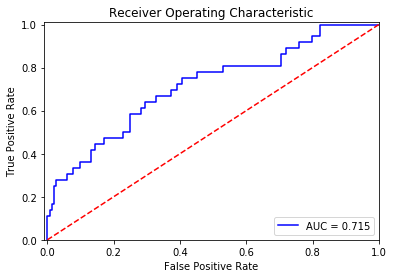

In [73]:
train_preds = tvs_train_preds.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = train_preds.prob1
y = train_preds.label
plot_roc(y,preds)

### Test Results

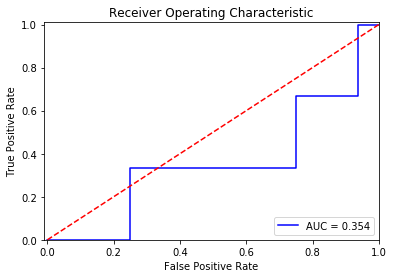

In [74]:
test_preds = tvs_test_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

### Analysis of Logistic Regression with Parameter Tuning

This model is still overfit because the AUC drops by about .1 from training to test sets but it is a lot better than the first logistic regression with no regularization. An AUC of .58 is not that good though another type of model can be used like GBTree that may model our data better.

## GBTree

In [75]:
gbt = GBTClassifier(maxIter=10)

model = gbt.fit(train)
# Make predictions
gbt_train_predictions = model.transform(train)
gbt_predictions = model.transform(validation)

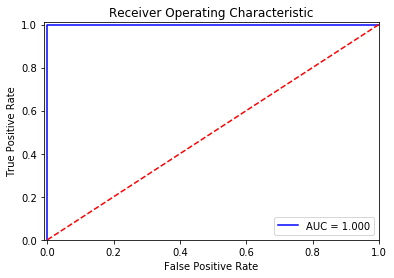

In [76]:
training_preds = gbt_train_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = training_preds.prob1
y = training_preds.label
plot_roc(y,preds)

### Test Results

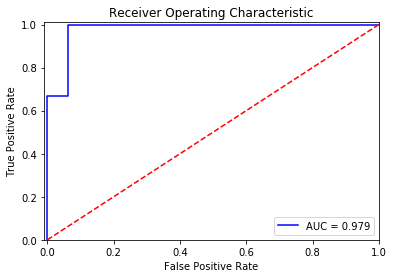

In [77]:
test_preds = gbt_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

### Feature Analysis

In [78]:
featImps = model.featureImportances.toArray()
varNames = ['countThumbsUp','percThumbsUp','countThumbsDown','totalThumbs','countLogins','countFriends',
 'countErrors','errorsPerLogin','countHelp','helpPerLogin','countSong','songsPerLogin','meanLevel']

importance = pd.DataFrame({"FeatureImportance":featImps,"Names":varNames}).sort_values("FeatureImportance")
importance.sort_values("FeatureImportance",ascending = False)

,FeatureImportance,Names
7,0.151113,errorsPerLogin
2,0.148080,countThumbsDown
0,0.109106,countThumbsUp
12,0.105253,meanLevel
5,0.095961,countFriends
4,0.089919,countLogins
11,0.085595,songsPerLogin
8,0.080834,countHelp
9,0.038104,helpPerLogin
10,0.035911,countSong


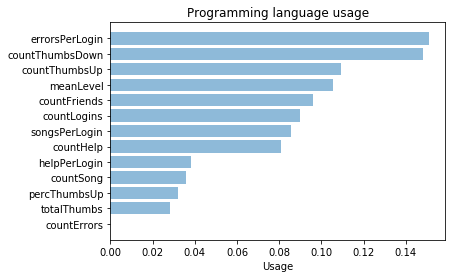

In [79]:
y_pos = np.arange(len(importance.Names))

plt.barh(y_pos, importance.FeatureImportance, align='center', alpha=0.5)
plt.yticks(y_pos, importance.Names)
plt.xlabel('Usage')
plt.title('Programming language usage')

plt.show()

### Analysis of Logistic Regression with Parameter Tuning

This model is performs really well especially for only a few features. We can see that the most important features to the model are errors per login and count of thumbs down with the rest of the features still having a moderate importance.

We are able to predict the training data perfectly with an AUC of 1 and the test data very well with an AUC of 0.979

The main thing that would help to determine how extensible this model is to the entire userbase would be to get more data and apply the GBTree method I demonstrated with the same features and see how it extends to the rest of the users. 